### aim: 

### date: 

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [4]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

In [48]:
def make_yearlist_ERA(yrst, yrend):
    
    baseDir = '/gpfs/data/greenocean/software/products/windsFromComponents/ERA5_v202303_rawdat/daily'

    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/ERA5_y{yrs[i]}_wspd10m_seas_rg.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

def make_yearlist_UKESM(yrst, yrend, sc = '1A'):
    
    baseDir = '//gpfs/data/greenocean/software/products/windsFromComponents/symlinked_hrly_UKESM/daily/'

    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/UKESM_{sc}_y{yrs[i]}_wspd10m_seas_rg.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist


ylist_UKESM = xr.open_mfdataset(make_yearlist_UKESM(1940,2019))
ylist_UKESM_2A = xr.open_mfdataset(make_yearlist_UKESM(1940,2019, sc = '2A'))
ylist_ERA = xr.open_mfdataset(make_yearlist_ERA(1940,2019))

cdomask = xr.open_dataset('/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/PlankTOMmask_krg.nc')
tmask = cdomask.aream2.mean(dim = 'time_counter')



In [49]:
baseDir = '//gpfs/data/greenocean/software/products/windsFromComponents/symlinked_hrly_UKESM/daily/' 
q = xr.open_dataset(f'{baseDir}/UKESM_1A_y2000_wspd10m_seas_rg.nc')
q2 = xr.open_dataset(f'{baseDir}/UKESM_2A_y2000_wspd10m_seas_rg.nc')
q
print(np.max(q.wspd10m.values - q2.wspd10m.values))

3.6360446638531148


In [47]:
q

<xarray.Dataset>
Dimensions:       (lat: 180, lon: 360, time_counter: 4)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2000-01-15 ... 2000-10-15
  * lon           (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat           (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables:
    wspd10m       (time_counter, lat, lon) float64 4.671 4.691 ... 5.006 5.001
Attributes:
    made in:  /gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/U...

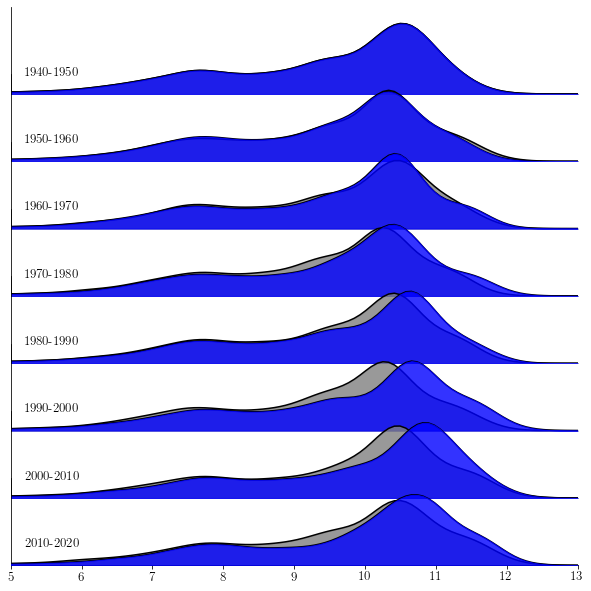

In [69]:
from scipy.stats.kde import gaussian_kde
from scipy.stats import norm

fact = 0.7
fig, axs = plt.subplots(8,1, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()


x_min, x_max = 5, 13
x_values = np.linspace(x_min, x_max, 100)
llim = -50

ax_objs = []
for i in range(0,8):
    tst = 1940+i*10
    ten = 1940+i*10+10
    
    w_UKESM = ylist_UKESM.wspd10m.sel(time_counter=slice(f'{tst}-01-01', f'{ten}-01-01')).sel(lat=slice(-90,llim)).mean(dim = 'time_counter')
    w_UKESM_2A = ylist_UKESM_2A.wspd10m.sel(time_counter=slice(f'{tst}-01-01', f'{ten}-01-01')).sel(lat=slice(-90,llim)).mean(dim = 'time_counter')
    w_ERA = ylist_ERA.wspd10m.sel(time_counter=slice(f'{tst}-01-01', f'{ten}-01-01')).sel(lat=slice(-90,llim)).mean(dim = 'time_counter')
    tmask = cdomask.aream2.mean(dim = 'time_counter').sel(lat=slice(-90,llim))


    # Convert data and weights to xarray DataArray
    data_array = np.ravel(twspd.values)
    weights_array = np.ravel(tmask.values)

    # Step 2: Calculate the KDE
    # Create a gaussian_kde object, including weights
    kde_ukesm = gaussian_kde(np.ravel(w_UKESM.values), weights=np.ravel(tmask.values))
    kde_ukesm_values = kde_ukesm(x_values)
    kde_ukesm_2A = gaussian_kde(np.ravel(w_UKESM_2A.values), weights=np.ravel(tmask.values))
    kde_ukesm_2A_values = kde_ukesm_2A(x_values)
    kde_era = gaussian_kde(np.ravel(w_ERA.values), weights=np.ravel(tmask.values))
    kde_era_values = kde_era(x_values)

    # Step 3: Plot the KDE

    
    axs[i].plot(x_values, kde_ukesm_2A_values, label='Weighted ukesm', color = 'k')
    axs[i].fill_between(x_values, np.zeros_like(kde_ukesm_2A_values), kde_ukesm_2A_values, color = 'grey', alpha = 0.8)

    axs[i].plot(x_values, kde_ukesm_values, label='Weighted ukesm', color = 'k')
    axs[i].fill_between(x_values, np.zeros_like(kde_ukesm_values), kde_ukesm_values, color = 'b', alpha = 0.8, zorder = 20)
    # axs[i].plot(x_values, kde_era_values, label='Weighted era',  color = 'w')
    # axs[i].fill_between(x_values, np.zeros_like(kde_era_values), kde_era_values, color = 'k', alpha = 0.6)
    axs[i].set_ylim(0,0.5)
    axs[i].set_xlim([x_min, x_max])
    axs[i].yaxis.set_visible(False)
    axs[i].patch.set_alpha(0)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].text(5.2,0.1,s = f'{tst}-{ten}')
    if i < 7:
        axs[i].spines['bottom'].set_visible(False)
        axs[i].set_xticklabels([])
        axs[i].tick_params(axis='x', length=0)
    
    # for ax in axs:
    #     ax.set_xlim(5,13)
    #     ax.set_ylim(0,0.3)
overlap = 0.3
h_pad = 5 + (- 5*(1 + overlap))
fig.tight_layout(h_pad=h_pad)
        

# gs.update(hspace=-2)

In [140]:
def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

In [148]:
from scipy.stats.kde import gaussian_kde
from scipy.stats import norm

overlap = 0.42
x_min, x_max = 2, 13
talph = 0.5
x_values = np.linspace(x_min, x_max, 100)
dmax = 0.55 #max of cde



llim = -30
tcol1 = 'b'
tcol = 'k'
fs = 18
tlab1 = 'no ozone\n depletion'
tlab2 = 'historic'
n95 = False

tdat1 = ylist_UKESM
tdat2 = ylist_UKESM_2A
fnam1 = 'ukesm-ozone-DJF-30.png'
fnam2 = 'ukesm-ozone-FY-30.png'

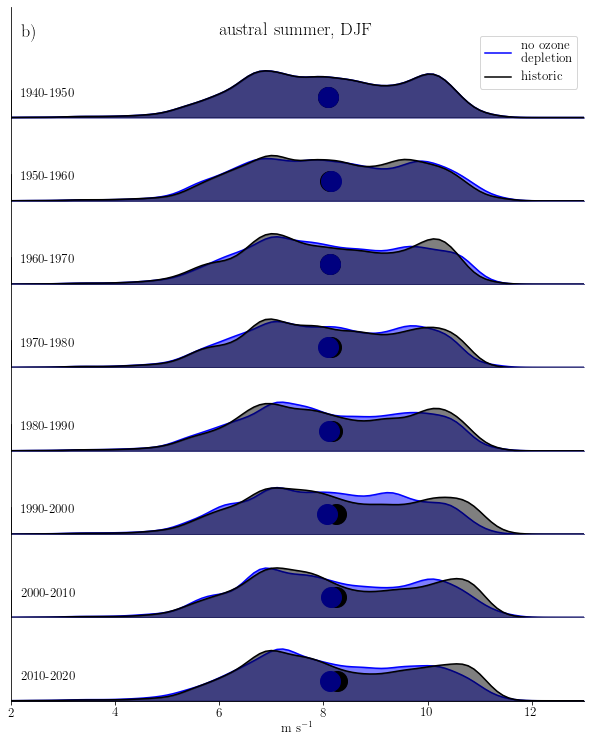

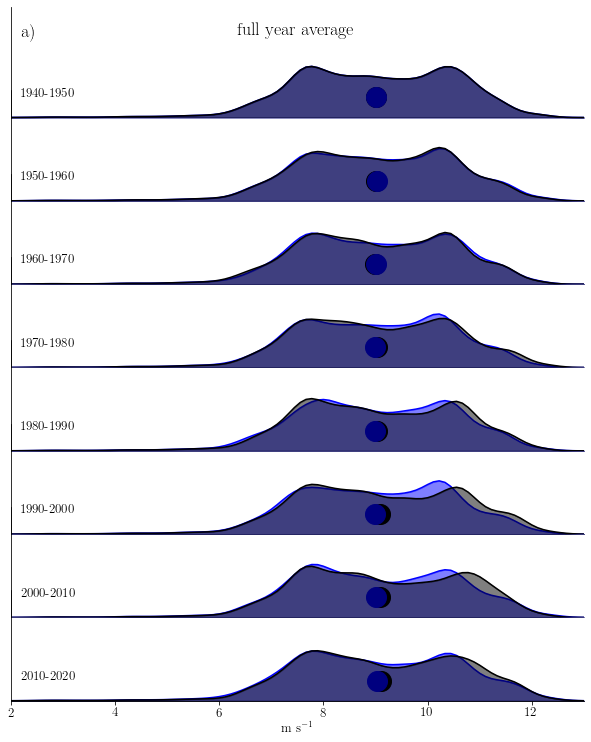

In [149]:
fact = 0.7
fig, axs = plt.subplots(8,1, figsize=(12*fact, 15*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(0,8):
    tst = 1940+i*10
    ten = 1940+i*10+10
    
    w_UKESM = tdat1.wspd10m.sel(time_counter=slice(f'{tst}-01-01', f'{ten}-01-01'))
    w_UKESM=w_UKESM.sel(time_counter=(w_UKESM['time_counter.season'] == 'DJF')).sel(lat=slice(-90,llim)).mean(dim = 'time_counter')
    
    w_UKESM_2A = tdat2.wspd10m.sel(time_counter=slice(f'{tst}-01-01', f'{ten}-01-01'))
    w_UKESM_2A=w_UKESM_2A.sel(time_counter=(w_UKESM_2A['time_counter.season'] == 'DJF')).sel(lat=slice(-90,llim)).mean(dim = 'time_counter')

    tmask = cdomask.aream2.mean(dim = 'time_counter').sel(lat=slice(-90,llim))
    
    n95_ukesm = weighted_quantile(np.ravel(w_UKESM.values), 0.95, sample_weight=np.ravel(tmask.values)) 
    n95_ukesm_2A = weighted_quantile(np.ravel(w_UKESM_2A.values), 0.95, sample_weight=np.ravel(tmask.values)) 

    
    avg_ukesm_2A = np.average(np.ravel(w_UKESM_2A.values), weights=np.ravel(tmask.values))
    avg_ukesm = np.average(np.ravel(w_UKESM.values), weights=np.ravel(tmask.values))
    
    # Step 2: Calculate the KDE
    # Create a gaussian_kde object, including weights
    kde_ukesm = gaussian_kde(np.ravel(w_UKESM.values), weights=np.ravel(tmask.values))
    kde_ukesm_values = kde_ukesm(x_values)
    kde_ukesm_2A = gaussian_kde(np.ravel(w_UKESM_2A.values), weights=np.ravel(tmask.values))
    kde_ukesm_2A_values = kde_ukesm_2A(x_values)
    
    if n95:
        axs[i].plot(n95_ukesm,0.1, marker = '|', color = tcol, markersize = 100)
        axs[i].plot(n95_ukesm_2A,0.1, marker = '|', color = tcol1, markersize = 100)

    axs[i].plot(avg_ukesm,0.1, marker = 'o', color = tcol, markersize = 20)
    axs[i].plot(avg_ukesm_2A,0.1, marker = 'o', color = tcol1, markersize = 20) 

    axs[i].plot(x_values, kde_ukesm_2A_values, label=tlab1, color = tcol1)
    axs[i].fill_between(x_values, np.zeros_like(kde_ukesm_2A_values), kde_ukesm_2A_values, color = tcol1, alpha = talph, )
   
    axs[i].plot(x_values, kde_ukesm_values, label=tlab2, color = tcol)
    axs[i].fill_between(x_values, np.zeros_like(kde_ukesm_values), kde_ukesm_values, color = tcol, alpha = talph, zorder = 20)

    axs[i].set_ylim(0,dmax)
    axs[i].set_xlim([x_min, x_max])
    axs[i].yaxis.set_visible(False)
    axs[i].patch.set_alpha(0)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].text(x_min + 0.2,0.1,s = f'{tst}-{ten}')
    if i < 7:
        axs[i].spines['bottom'].set_visible(False)
        axs[i].set_xticklabels([])
        axs[i].tick_params(axis='x', length=0)
    
axs[7].set_xlabel('m s$^{-1}$')
    # for ax in axs:
    #     ax.set_xlim(5,13)
    #     ax.set_ylim(0,0.3)
overlap = 0.42
h_pad = 5 + (- 5*(1 + overlap))
fig.tight_layout(h_pad=h_pad)

axs[0].legend(loc = 'center right')
axs[0].text(x_min + 0.2, 0.4, 'b)', fontsize =fs)
#plt.suptitle('Austral summer overwater wind speed distribution south of -50$^{\circ}$S \n circles denote the weighted mean', y = 1.02)
plt.suptitle('austral summer, DJF', y = 0.96, fontsize = fs)# overwater wind speed distribution south of -50$^{\circ}$S \n circles denote the weighted mean', y = 1.02)
plt.savefig(f'./plts/{fnam1}')
################
fact = 0.7
fig, axs = plt.subplots(8,1, figsize=(12*fact, 15*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(0,8):
    tst = 1940+i*10
    ten = 1940+i*10+10
    
    w_UKESM = tdat1.wspd10m.sel(time_counter=slice(f'{tst}-01-01', f'{ten}-01-01'))
    w_UKESM=w_UKESM.sel(lat=slice(-90,llim)).mean(dim = 'time_counter')
    
    w_UKESM_2A = tdat2.wspd10m.sel(time_counter=slice(f'{tst}-01-01', f'{ten}-01-01'))
    w_UKESM_2A=w_UKESM_2A.sel(lat=slice(-90,llim)).mean(dim = 'time_counter')

    tmask = cdomask.aream2.mean(dim = 'time_counter').sel(lat=slice(-90,llim))
    
    n95_ukesm = weighted_quantile(np.ravel(w_UKESM.values), 0.95, sample_weight=np.ravel(tmask.values)) 
    n95_ukesm_2A = weighted_quantile(np.ravel(w_UKESM_2A.values), 0.95, sample_weight=np.ravel(tmask.values)) 

    
    avg_ukesm_2A = np.average(np.ravel(w_UKESM_2A.values), weights=np.ravel(tmask.values))
    avg_ukesm = np.average(np.ravel(w_UKESM.values), weights=np.ravel(tmask.values))
    
    # Step 2: Calculate the KDE
    # Create a gaussian_kde object, including weights
    kde_ukesm = gaussian_kde(np.ravel(w_UKESM.values), weights=np.ravel(tmask.values))
    kde_ukesm_values = kde_ukesm(x_values)
    kde_ukesm_2A = gaussian_kde(np.ravel(w_UKESM_2A.values), weights=np.ravel(tmask.values))
    kde_ukesm_2A_values = kde_ukesm_2A(x_values)
    
    if n95:
        axs[i].plot(n95_ukesm,0.1, marker = '|', color = tcol, markersize = 100)
        axs[i].plot(n95_ukesm_2A,0.1, marker = '|', color = tcol1, markersize = 100)

    axs[i].plot(avg_ukesm,0.1, marker = 'o', color = tcol, markersize = 20)
    axs[i].plot(avg_ukesm_2A,0.1, marker = 'o', color = tcol1, markersize = 20) 

    axs[i].plot(x_values, kde_ukesm_2A_values, label=tlab1, color = tcol1)
    axs[i].fill_between(x_values, np.zeros_like(kde_ukesm_2A_values), kde_ukesm_2A_values, color = tcol1, alpha = talph, )
   
    axs[i].plot(x_values, kde_ukesm_values, label=tlab2, color = tcol)
    axs[i].fill_between(x_values, np.zeros_like(kde_ukesm_values), kde_ukesm_values, color = tcol, alpha = talph, zorder = 20)

    axs[i].set_ylim(0,dmax)
    axs[i].set_xlim([x_min, x_max])
    axs[i].yaxis.set_visible(False)
    axs[i].patch.set_alpha(0)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].text(x_min + 0.2,0.1,s = f'{tst}-{ten}')
    if i < 7:
        axs[i].spines['bottom'].set_visible(False)
        axs[i].set_xticklabels([])
        axs[i].tick_params(axis='x', length=0)
    
axs[7].set_xlabel('m s$^{-1}$')
    # for ax in axs:
    #     ax.set_xlim(5,13)
    #     ax.set_ylim(0,0.3)
overlap = 0.42
h_pad = 5 + (- 5*(1 + overlap))
fig.tight_layout(h_pad=h_pad)

# axs[0].legend(loc = 'center right')
axs[0].text(x_min + 0.2, 0.4, 'a)', fontsize =fs)
#plt.suptitle('Austral summer overwater wind speed distribution south of -50$^{\circ}$S \n circles denote the weighted mean', y = 1.02)
plt.suptitle('full year average', y = 0.96, fontsize = fs)# overwater wind speed distribution south of -50$^{\circ}$S \n circles denote the weighted mean', y = 1.02)
       
plt.savefig(f'./plts/{fnam2}')
# gs.update(hspace=-2)

### era vs ukesm

In [146]:
from scipy.stats.kde import gaussian_kde
from scipy.stats import norm

overlap = 0.42
x_min, x_max = 2, 13
talph = 0.5
x_values = np.linspace(x_min, x_max, 100)
dmax = 0.55 #max of cde



llim = -30
tcol1 = 'b'
tcol = 'k'
fs = 18
tlab1 = 'ERA5'
tlab2 = 'UKESM1.1'
n95 = False

tdat1 = ylist_UKESM
tdat2 = ylist_ERA
fnam1 = 'ukesm-era-DJF-30.png'
fnam2 = 'ukesm-era-FY-30.png'

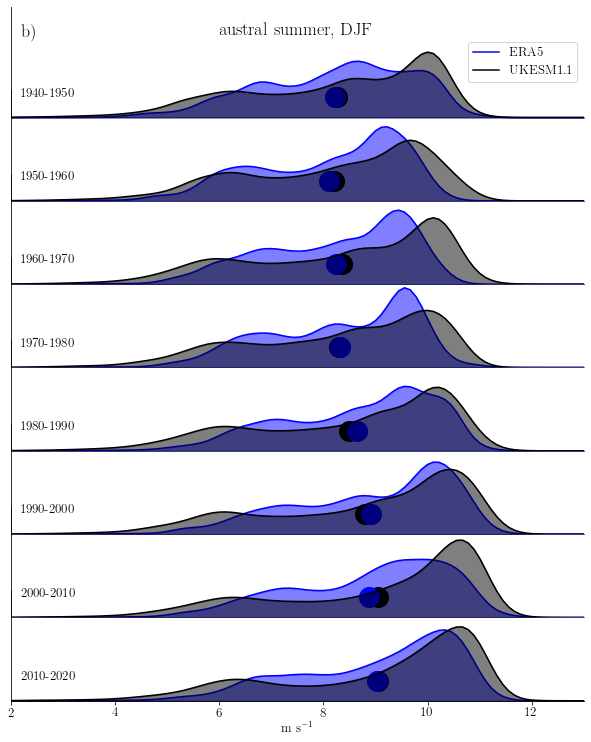

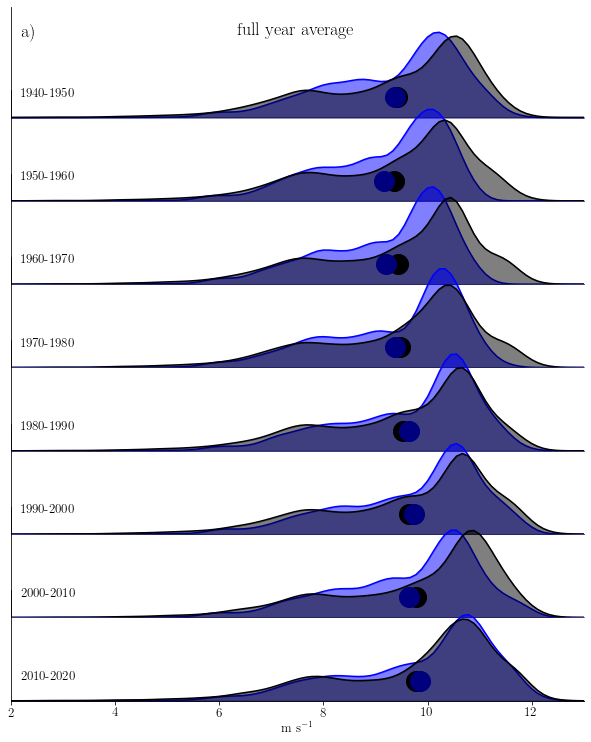

In [147]:
fact = 0.7
fig, axs = plt.subplots(8,1, figsize=(12*fact, 15*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(0,8):
    tst = 1940+i*10
    ten = 1940+i*10+10
    
    w_UKESM = tdat1.wspd10m.sel(time_counter=slice(f'{tst}-01-01', f'{ten}-01-01'))
    w_UKESM=w_UKESM.sel(time_counter=(w_UKESM['time_counter.season'] == 'DJF')).sel(lat=slice(-90,llim)).mean(dim = 'time_counter')
    
    w_UKESM_2A = tdat2.wspd10m.sel(time_counter=slice(f'{tst}-01-01', f'{ten}-01-01'))
    w_UKESM_2A=w_UKESM_2A.sel(time_counter=(w_UKESM_2A['time_counter.season'] == 'DJF')).sel(lat=slice(-90,llim)).mean(dim = 'time_counter')

    tmask = cdomask.aream2.mean(dim = 'time_counter').sel(lat=slice(-90,llim))
    
    n95_ukesm = weighted_quantile(np.ravel(w_UKESM.values), 0.95, sample_weight=np.ravel(tmask.values)) 
    n95_ukesm_2A = weighted_quantile(np.ravel(w_UKESM_2A.values), 0.95, sample_weight=np.ravel(tmask.values)) 

    
    avg_ukesm_2A = np.average(np.ravel(w_UKESM_2A.values), weights=np.ravel(tmask.values))
    avg_ukesm = np.average(np.ravel(w_UKESM.values), weights=np.ravel(tmask.values))
    
    # Step 2: Calculate the KDE
    # Create a gaussian_kde object, including weights
    kde_ukesm = gaussian_kde(np.ravel(w_UKESM.values), weights=np.ravel(tmask.values))
    kde_ukesm_values = kde_ukesm(x_values)
    kde_ukesm_2A = gaussian_kde(np.ravel(w_UKESM_2A.values), weights=np.ravel(tmask.values))
    kde_ukesm_2A_values = kde_ukesm_2A(x_values)
    
    if n95:
        axs[i].plot(n95_ukesm,0.1, marker = '|', color = tcol, markersize = 100)
        axs[i].plot(n95_ukesm_2A,0.1, marker = '|', color = tcol1, markersize = 100)

    axs[i].plot(avg_ukesm,0.1, marker = 'o', color = tcol, markersize = 20)
    axs[i].plot(avg_ukesm_2A,0.1, marker = 'o', color = tcol1, markersize = 20) 

    axs[i].plot(x_values, kde_ukesm_2A_values, label=tlab1, color = tcol1)
    axs[i].fill_between(x_values, np.zeros_like(kde_ukesm_2A_values), kde_ukesm_2A_values, color = tcol1, alpha = talph, )
   
    axs[i].plot(x_values, kde_ukesm_values, label=tlab2, color = tcol)
    axs[i].fill_between(x_values, np.zeros_like(kde_ukesm_values), kde_ukesm_values, color = tcol, alpha = talph, zorder = 20)

    axs[i].set_ylim(0,dmax)
    axs[i].set_xlim([x_min, x_max])
    axs[i].yaxis.set_visible(False)
    axs[i].patch.set_alpha(0)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].text(x_min + 0.2,0.1,s = f'{tst}-{ten}')
    if i < 7:
        axs[i].spines['bottom'].set_visible(False)
        axs[i].set_xticklabels([])
        axs[i].tick_params(axis='x', length=0)
    
axs[7].set_xlabel('m s$^{-1}$')
    # for ax in axs:
    #     ax.set_xlim(5,13)
    #     ax.set_ylim(0,0.3)
overlap = 0.42
h_pad = 5 + (- 5*(1 + overlap))
fig.tight_layout(h_pad=h_pad)

axs[0].legend(loc = 'center right')
axs[0].text(x_min + 0.2, 0.4, 'b)', fontsize =fs)
#plt.suptitle('Austral summer overwater wind speed distribution south of -50$^{\circ}$S \n circles denote the weighted mean', y = 1.02)
plt.suptitle('austral summer, DJF', y = 0.96, fontsize = fs)# overwater wind speed distribution south of -50$^{\circ}$S \n circles denote the weighted mean', y = 1.02)
plt.savefig(f'./plts/{fnam1}')
################
fact = 0.7
fig, axs = plt.subplots(8,1, figsize=(12*fact, 15*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(0,8):
    tst = 1940+i*10
    ten = 1940+i*10+10
    
    w_UKESM = tdat1.wspd10m.sel(time_counter=slice(f'{tst}-01-01', f'{ten}-01-01'))
    w_UKESM=w_UKESM.sel(lat=slice(-90,llim)).mean(dim = 'time_counter')
    
    w_UKESM_2A = tdat2.wspd10m.sel(time_counter=slice(f'{tst}-01-01', f'{ten}-01-01'))
    w_UKESM_2A=w_UKESM_2A.sel(lat=slice(-90,llim)).mean(dim = 'time_counter')

    tmask = cdomask.aream2.mean(dim = 'time_counter').sel(lat=slice(-90,llim))
    
    n95_ukesm = weighted_quantile(np.ravel(w_UKESM.values), 0.95, sample_weight=np.ravel(tmask.values)) 
    n95_ukesm_2A = weighted_quantile(np.ravel(w_UKESM_2A.values), 0.95, sample_weight=np.ravel(tmask.values)) 

    
    avg_ukesm_2A = np.average(np.ravel(w_UKESM_2A.values), weights=np.ravel(tmask.values))
    avg_ukesm = np.average(np.ravel(w_UKESM.values), weights=np.ravel(tmask.values))
    
    # Step 2: Calculate the KDE
    # Create a gaussian_kde object, including weights
    kde_ukesm = gaussian_kde(np.ravel(w_UKESM.values), weights=np.ravel(tmask.values))
    kde_ukesm_values = kde_ukesm(x_values)
    kde_ukesm_2A = gaussian_kde(np.ravel(w_UKESM_2A.values), weights=np.ravel(tmask.values))
    kde_ukesm_2A_values = kde_ukesm_2A(x_values)
    
    if n95:
        axs[i].plot(n95_ukesm,0.1, marker = '|', color = tcol, markersize = 100)
        axs[i].plot(n95_ukesm_2A,0.1, marker = '|', color = tcol1, markersize = 100)

    axs[i].plot(avg_ukesm,0.1, marker = 'o', color = tcol, markersize = 20)
    axs[i].plot(avg_ukesm_2A,0.1, marker = 'o', color = tcol1, markersize = 20) 

    axs[i].plot(x_values, kde_ukesm_2A_values, label=tlab1, color = tcol1)
    axs[i].fill_between(x_values, np.zeros_like(kde_ukesm_2A_values), kde_ukesm_2A_values, color = tcol1, alpha = talph, )
   
    axs[i].plot(x_values, kde_ukesm_values, label=tlab2, color = tcol)
    axs[i].fill_between(x_values, np.zeros_like(kde_ukesm_values), kde_ukesm_values, color = tcol, alpha = talph, zorder = 20)

    axs[i].set_ylim(0,dmax)
    axs[i].set_xlim([x_min, x_max])
    axs[i].yaxis.set_visible(False)
    axs[i].patch.set_alpha(0)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].text(x_min + 0.2,0.1,s = f'{tst}-{ten}')
    if i < 7:
        axs[i].spines['bottom'].set_visible(False)
        axs[i].set_xticklabels([])
        axs[i].tick_params(axis='x', length=0)
    
axs[7].set_xlabel('m s$^{-1}$')
    # for ax in axs:
    #     ax.set_xlim(5,13)
    #     ax.set_ylim(0,0.3)
overlap = 0.42
h_pad = 5 + (- 5*(1 + overlap))
fig.tight_layout(h_pad=h_pad)

# axs[0].legend(loc = 'center right')
axs[0].text(x_min + 0.2, 0.4, 'a)', fontsize =fs)
#plt.suptitle('Austral summer overwater wind speed distribution south of -50$^{\circ}$S \n circles denote the weighted mean', y = 1.02)
plt.suptitle('full year average', y = 0.96, fontsize = fs)# overwater wind speed distribution south of -50$^{\circ}$S \n circles denote the weighted mean', y = 1.02)
       
plt.savefig(f'./plts/{fnam2}')
# gs.update(hspace=-2)

## bordelkod

Text(0.5, 0.97, 'Full year average')

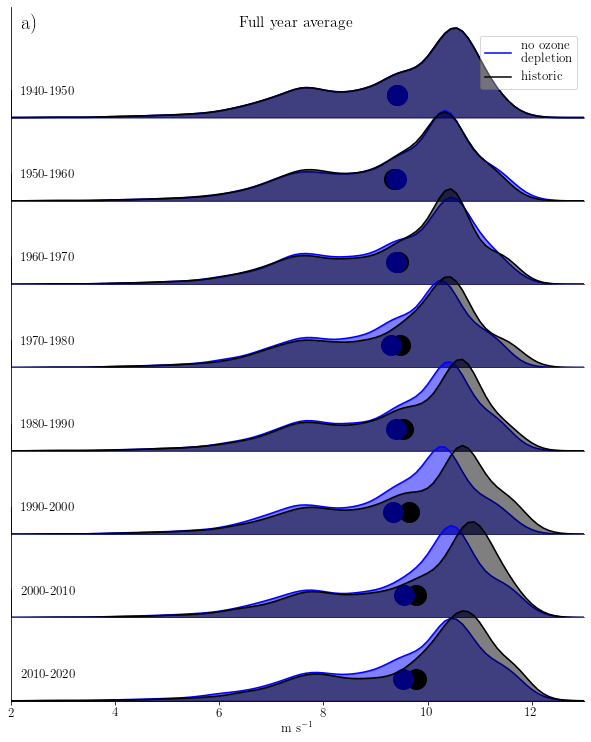

In [129]:
from scipy.stats.kde import gaussian_kde
from scipy.stats import norm

fact = 0.7
fig, axs = plt.subplots(8,1, figsize=(12*fact, 15*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()


talph = 0.5

x_min, x_max = 2, 13
x_values = np.linspace(x_min, x_max, 100)
llim = -50
tcol1 = 'b'
tcol = 'k'

ax_objs = []
for i in range(0,8):
    tst = 1940+i*10
    ten = 1940+i*10+10
    
    w_UKESM = ylist_UKESM.wspd10m.sel(time_counter=slice(f'{tst}-01-01', f'{ten}-01-01'))
    w_UKESM=w_UKESM.sel(lat=slice(-90,llim)).mean(dim = 'time_counter')
    
    w_UKESM_2A = ylist_UKESM_2A.wspd10m.sel(time_counter=slice(f'{tst}-01-01', f'{ten}-01-01'))
    w_UKESM_2A=w_UKESM_2A.sel(lat=slice(-90,llim)).mean(dim = 'time_counter')
    
    
    
    # w_UKESM_2A = ylist_UKESM_2A.wspd10m.sel(time_counter=slice(f'{tst}-01-01', f'{ten}-01-01')).sel(time_counter.season = 'DJF').sel(lat=slice(-90,llim)).mean(dim = 'time_counter')
    # w_ERA = ylist_ERA.wspd10m.sel(time_counter=slice(f'{tst}-01-01', f'{ten}-01-01')).sel(time_counter.season = 'DJF').sel(lat=slice(-90,llim)).mean(dim = 'time_counter')
    tmask = cdomask.aream2.mean(dim = 'time_counter').sel(lat=slice(-90,llim))


    # Convert data and weights to xarray DataArray
    data_array = np.ravel(twspd.values)
    weights_array = np.ravel(tmask.values)
    
    n95_ukesm = weighted_quantile(np.ravel(w_UKESM.values), 0.95, sample_weight=np.ravel(tmask.values)) 
    n95_ukesm_2A = weighted_quantile(np.ravel(w_UKESM_2A.values), 0.95, sample_weight=np.ravel(tmask.values)) 

    
    avg_ukesm_2A = np.average(np.ravel(w_UKESM_2A.values), weights=np.ravel(tmask.values))
    avg_ukesm = np.average(np.ravel(w_UKESM.values), weights=np.ravel(tmask.values))
    
    # Step 2: Calculate the KDE
    # Create a gaussian_kde object, including weights
    kde_ukesm = gaussian_kde(np.ravel(w_UKESM.values), weights=np.ravel(tmask.values))
    kde_ukesm_values = kde_ukesm(x_values)
    kde_ukesm_2A = gaussian_kde(np.ravel(w_UKESM_2A.values), weights=np.ravel(tmask.values))
    kde_ukesm_2A_values = kde_ukesm_2A(x_values)
    
    # axs[i].plot(n95_ukesm,0.1, marker = '|', color = tcol, markersize = 100)
    # axs[i].plot(n95_ukesm_2A,0.1, marker = '|', color = tcol1, markersize = 100)

    axs[i].plot(avg_ukesm,0.1, marker = 'o', color = tcol, markersize = 20)
    axs[i].plot(avg_ukesm_2A,0.1, marker = 'o', color = tcol1, markersize = 20) 

    axs[i].plot(x_values, kde_ukesm_2A_values, label='no ozone\n depletion', color = tcol1)
    axs[i].fill_between(x_values, np.zeros_like(kde_ukesm_2A_values), kde_ukesm_2A_values, color = tcol1, alpha = talph, )
    

    
    axs[i].plot(x_values, kde_ukesm_values, label='historic', color = tcol)
    axs[i].fill_between(x_values, np.zeros_like(kde_ukesm_values), kde_ukesm_values, color = tcol, alpha = talph, zorder = 20)
    # axs[i].plot(x_values, kde_era_values, label='Weighted era',  color = 'w')
    # axs[i].fill_between(x_values, np.zeros_like(kde_era_values), kde_era_values, color = 'k', alpha = 0.6)
    axs[i].set_ylim(0,0.5)
    axs[i].set_xlim([x_min, x_max])
    axs[i].yaxis.set_visible(False)
    axs[i].patch.set_alpha(0)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].text(x_min + 0.2,0.1,s = f'{tst}-{ten}')
    if i < 7:
        axs[i].spines['bottom'].set_visible(False)
        axs[i].set_xticklabels([])
        axs[i].tick_params(axis='x', length=0)
    
axs[7].set_xlabel('m s$^{-1}$')
    # for ax in axs:
    #     ax.set_xlim(5,13)
    #     ax.set_ylim(0,0.3)

h_pad = 5 + (- 5*(1 + overlap))
fig.tight_layout(h_pad=h_pad)

axs[0].legend(loc = 'center right')
axs[0].text(x_min + 0.2, 0.4, 'a)', fontsize =20)
#plt.suptitle('Austral summer overwater wind speed distribution south of -50$^{\circ}$S \n circles denote the weighted mean', y = 1.02)
plt.suptitle('Full year average', y = 0.97)# overwater wind speed distribution south of -50$^{\circ}$S \n circles denote the weighted mean', y = 1.02)
       

# gs.update(hspace=-2)